## Cell cluster for assigning to 5 layers of H&E stain

In [2]:
import pandas as pd
import numpy as np

# !pip install scikit-image
from skimage import data

import sys
sys.path.append('../../scGCO_code/')
from scGCO_source import *

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

D:\Annconda3\envs\spatial\lib\site-packages\pysal\lib\weights\util.py:19: UserWarning: geopandas not available. Some functionality will be disabled.
  warn('geopandas not available. Some functionality will be disabled.')


raw data dim: (262, 16218)
Number of expressed genes a spot must have to be kept (0.01% of total expressed genes) 3375
Marked 3 spots
Removing genes that are expressed in less than 3 spots with a count of at least 1
Dropped 1559 genes
Remain Points (262, 14659)
raw data dim: (262, 16218)
Number of expressed genes a spot must have to be kept (0.0% of total expressed genes) 3
Marked 0 spots
Removing genes that are expressed in less than 0 spots with a count of at least 0
Dropped 0 genes
Rep11 drop points (262, 16218)


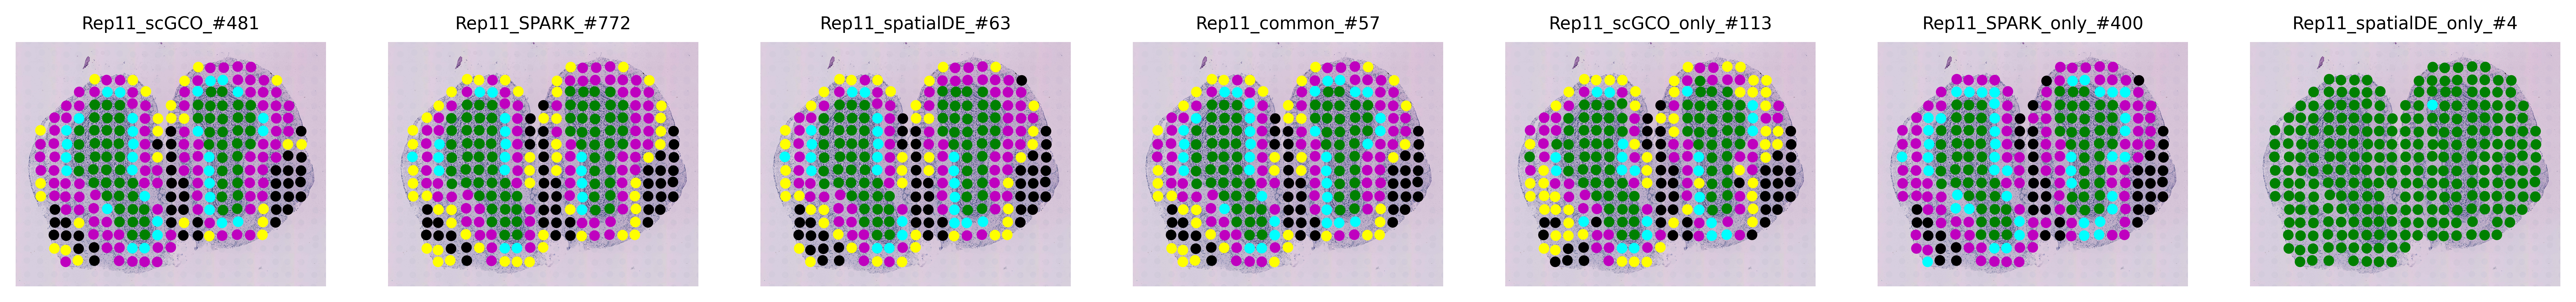

In [7]:
## Task2---Kmeans_labels  11  comparing with SPARK

j=11
start_sf=10
unary_scale_factor=100
label_cost=10
algorithm='expansion'
ff="../../../data/Raw_data/MOB-breast_cancer/Rep11_MOB_count_matrix-1.tsv"

## 1.filter
locs, data, noiseInd=read_spatial_expression(ff,sep='\t',
                                            drop = False)
data_norm = normalize_count_cellranger(data)
exp= data_norm.iloc[:,0]
cellGraph= create_graph_with_weight(locs, exp)
print('Remain Points {}'.format(data_norm.shape))


result_df =read_result_to_dataframe(
    '../../../results/MouseOB/scGCO_results/Rep{}_result_df.csv'.format(j))
scgco = result_df[result_df.fdr<0.01]
scGCO=scgco.index

spark = pd.read_csv('../../../results/MouseOB/SPARK_results/Rep'+str(j)+'_MOB_spark.csv')
SPARK =set(spark.genes.values)

de='../../../results/MouseOB/SpatialDE_results/MOB_'+str(j)+'_DE.csv'
de = pd.read_csv(de)
spatialDE=set(de.g.values)

common=set(scGCO)&set(SPARK)&set(spatialDE)
scGCO_only=(set(scGCO)-set(SPARK)-set(spatialDE))
spatialDE_only = (set(spatialDE) - set(scGCO)- set(SPARK)-set(common))
SPARK_only=(set(SPARK)-set(scGCO)-set(spatialDE)-set(common))

gene_df=['scGCO','SPARK','spatialDE','common','scGCO_only','SPARK_only','spatialDE_only']

if True:
    nrows=1
    ncols=7
    fig,ax=plt.subplots(nrows,ncols,figsize=(ncols*3,nrows*3),dpi=(600))   ## dpi=300
    for i,geneNames in enumerate(gene_df):
        genelist_a =eval(geneNames)
        genelist = set(genelist_a) & set(data_norm.columns)
        if len(genelist)>0:
            kmeans_labels,hmrf_labels=create_labels(locs,data_norm,genelist,cellGraph,
                                                    cluster_size=5,
                                                   unary_scale_factor=100,
                                                   smooth_factor=20,rs=541)
        else:
            ## Don't filter
            locs0, data0, _= read_spatial_expression(ff,sep='\s+',
                        num_exp_genes=0.0, num_exp_spots=0.0, min_expression=0,
                                                    drop = False)
            data_norm0 = normalize_count_cellranger(data0)
            exp0 = data_norm0.iloc[:,0]
            cellGraph0 = create_graph_with_weight(locs0, exp0)
            print('Rep{} drop points {}'.format(j, data_norm0.shape))
            genelist = set(genelist_a) & set(data_norm0.columns)  ## don't filter genes
            kmeans_labels,hmrf_labels=create_labels(locs0,data_norm0,genelist,cellGraph0,
                                                    cluster_size=5,
                                                   unary_scale_factor=100,
                                                   smooth_factor=20,rs=541)

        image='../../../data/Raw_data/HE-MOB-breast_cancer/HE_Rep{}_MOB.jpg'.format(j)
#         colors=['k','green','yellow','cyan','m'] 
        title='Rep{}_{}_#{}'.format(j,geneNames,len(genelist))  
        if i==0:
            colors=['g','k','yellow','m','cyan']
        if i==1:
            colors=['cyan','k','yellow','m','green']
        if i==2:
            colors=['cyan','k','yellow','g','m']
        if i==3:
            colors=['m','yellow','green','k','cyan'] 
        if i==4:
            colors=['cyan','yellow','k','m','g']
        if i==5:
            colors=['cyan','k','yellow','m','g']
        if i==6:
            colors=['g','m','k','yellow','cyan']
        axes=ax[i]
        subplot_HE_with_labels(locs,hmrf_labels,image,axes,colors,title,s=15)
        axes.axis('off')
        #subplot_HE_with_labels(locs,hmrf_labels,image,ax[1,i],colors,title,s=15)
    #     plt.savefig('../Data/Comment_pics/Rep{}_task2_kmeans_Pattern.pdf'.format(j))
    plt.show()

In [8]:
fig.savefig('../../../results/Figure/Supple_Fig8-Rep11_tissue_structure.pdf')